In [1]:
try:
    import openmdao.api as om
    import dymos as dm
except ImportError:
    !python -m pip install openmdao[notebooks]
    !python -m pip install dymos
    import openmdao.api as om
    import dymos as dm

# Supersonic Interceptor Minimum Time Climb

This example is based on the _A/C Min Time to Climb_ example given in
chapter 4 of Bryson {cite}`bryson1999dynamic`. It finds the
angle-of-attack history required to accelerate a supersonic interceptor
from near ground level, Mach 0.4 to an altitude of 20 km and Mach 1.0.

![The free-body-diagram of the min-time-climb problem.](min_time_climb_fbd.png)

The vehicle dynamics are given by

\begin{align}
  \frac{dv}{dt} &= \frac{T}{m} \cos \alpha - \frac{D}{m} - g \sin \gamma \\
  \frac{d\gamma}{dt} &= \frac{T}{m v} \sin \alpha + \frac{L}{m v} - \frac{g \cos \gamma}{v} \\
  \frac{dh}{dt} &= v \sin \gamma \\
  \frac{dr}{dt} &= v \cos \gamma \\
  \frac{dm}{dt} &= - \frac{T}{g I_{sp}}
\end{align}

The initial conditions are

\begin{align}
  r_0 &= 0 \rm{\,m} \\
  h_0 &= 100 \rm{\,m} \\
  v_0 &= 135.964 \rm{\,m/s} \\
  \gamma_0 &= 0 \rm{\,deg} \\
  m_0 &= 19030.468 \rm{\,kg}
\end{align}

and the final conditions are

\begin{align}
  h_f &= 20000 \rm{\,m} \\
  M_f &= 1.0 \\
  \gamma_0 &= 0 \rm{\,deg}
\end{align}

## The ODE System: min_time_climb_ode.py

The top level ODE definition is a _Group_ that connects several subsystems.

In [2]:
import openmdao.api as om
from dymos.models.eom import FlightPathEOM2D
from dymos.examples.min_time_climb.prop import PropGroup
from dymos.models.atmosphere import USatm1976Comp
from dymos.examples.min_time_climb.doc.aero_partial_coloring import AeroGroup

class MinTimeClimbODE(om.Group):

    def initialize(self):
        self.options.declare('num_nodes', types=int)
        self.options.declare('fd', types=bool, default=False, desc='If True, use fd for partials')
        self.options.declare('partial_coloring', types=bool, default=False,
                             desc='If True and fd is True, color the approximated partials')

    def setup(self):
        nn = self.options['num_nodes']

        self.add_subsystem(name='atmos',
                           subsys=USatm1976Comp(num_nodes=nn),
                           promotes_inputs=['h'])

        self.add_subsystem(name='aero',
                           subsys=AeroGroup(num_nodes=nn,
                                            fd=self.options['fd'],
                                            partial_coloring=self.options['partial_coloring']),
                           promotes_inputs=['v', 'alpha', 'S'])

        self.connect('atmos.sos', 'aero.sos')
        self.connect('atmos.rho', 'aero.rho')

        self.add_subsystem(name='prop',
                           subsys=PropGroup(num_nodes=nn),
                           promotes_inputs=['h', 'Isp', 'throttle'])

        self.connect('aero.mach', 'prop.mach')

        self.add_subsystem(name='flight_dynamics',
                           subsys=FlightPathEOM2D(num_nodes=nn),
                           promotes_inputs=['m', 'v', 'gam', 'alpha'])

        self.connect('aero.f_drag', 'flight_dynamics.D')
        self.connect('aero.f_lift', 'flight_dynamics.L')
        self.connect('prop.thrust', 'flight_dynamics.T')


## Building and running the problem

In the following code we follow the following process to solve the
problem:

INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings
INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings
Full total jacobian was computed 3 times, taking 0.288383 seconds.
Total jacobian shape: (181, 191) 


Jacobian shape: (181, 191)  ( 5.49% nonzero)
FWD solves: 13   REV solves: 0
Total colors vs. total size: 13 vs 191  (93.2% improvement)

Sparsity computed using tolerance: 1e-25
Time to compute sparsity: 0.288383 sec.
Time to compute coloring: 0.225464 sec.
Memory to compute coloring: 0.363281 MB.


/Users/dkilkenny/Desktop/OpenMDAO_Clone/openmdao/core/total_jac.py:1756: DerivativesWarning:Constraints or objectives [('traj.phases.phase0.path_constraints.path:h', inds=[(0, 0)]), ('traj.phases.phase0.path_constraints.path:mach', inds=[(0, 0)])] cannot be impacted by the design variables of the problem.




Optimization Problem -- Optimization using pyOpt_sparse
    Objective Function: _objfunc

    Solution: 
--------------------------------------------------------------------------------
    Total Time:                    9.0449
       User Objective Time :       2.0124
       User Sensitivity Time :     1.7767
       Interface Time :            2.0369
       Opt Solver Time:            3.2189
    Calls to Objective Function :     134
    Calls to Sens Function :          108


   Objectives
      Index  Name                                    Value          Optimum
          0  traj.phases.phase0.time.time     3.240596E+02     0.000000E+00

   Variables (c - continuous, i - integer, d - discrete)
      Index  Name                                                                Type      Lower Bound            Value      Upper Bound     Status
          0  traj.phases.phase0.time_extents.t_duration_0                           c     5.000000E-01     3.240596E+00     4.000000E+00        


Simulating trajectory traj
Done simulating trajectory traj


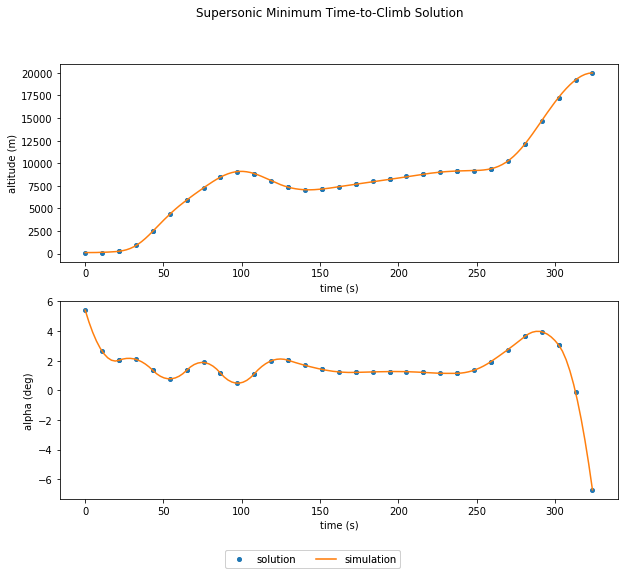

In [3]:
import matplotlib.pyplot as plt

import openmdao.api as om

import dymos as dm
from dymos.examples.min_time_climb.min_time_climb_ode import MinTimeClimbODE
from dymos.examples.plotting import plot_results

#
# Instantiate the problem and configure the optimization driver
#
p = om.Problem(model=om.Group())

p.driver = om.pyOptSparseDriver()
p.driver.options['optimizer'] = 'SLSQP'
p.driver.declare_coloring()

#
# Instantiate the trajectory and phase
#
traj = dm.Trajectory()

phase = dm.Phase(ode_class=MinTimeClimbODE,
                 transcription=dm.GaussLobatto(num_segments=15, compressed=False))

traj.add_phase('phase0', phase)

p.model.add_subsystem('traj', traj)

#
# Set the options on the optimization variables
# Note the use of explicit state units here since much of the ODE uses imperial units
# and we prefer to solve this problem using metric units.
#
phase.set_time_options(fix_initial=True, duration_bounds=(50, 400),
                       duration_ref=100.0)

phase.add_state('r', fix_initial=True, lower=0, upper=1.0E6, units='m',
                ref=1.0E3, defect_ref=1.0E3,
                rate_source='flight_dynamics.r_dot')

phase.add_state('h', fix_initial=True, lower=0, upper=20000.0, units='m',
                ref=1.0E2, defect_ref=1.0E2,
                rate_source='flight_dynamics.h_dot')

phase.add_state('v', fix_initial=True, lower=10.0, units='m/s',
                ref=1.0E2, defect_ref=1.0E2,
                rate_source='flight_dynamics.v_dot')

phase.add_state('gam', fix_initial=True, lower=-1.5, upper=1.5, units='rad',
                ref=1.0, defect_ref=1.0,
                rate_source='flight_dynamics.gam_dot')

phase.add_state('m', fix_initial=True, lower=10.0, upper=1.0E5, units='kg',
                ref=1.0E3, defect_ref=1.0E3,
                rate_source='prop.m_dot')

phase.add_control('alpha', units='deg', lower=-8.0, upper=8.0, scaler=1.0,
                  rate_continuity=True, rate_continuity_scaler=100.0,
                  rate2_continuity=False)

phase.add_parameter('S', val=49.2386, units='m**2', opt=False, targets=['S'])
phase.add_parameter('Isp', val=1600.0, units='s', opt=False, targets=['Isp'])
phase.add_parameter('throttle', val=1.0, opt=False, targets=['throttle'])

#
# Setup the boundary and path constraints
#
phase.add_boundary_constraint('h', loc='final', equals=20000, scaler=1.0E-3)
phase.add_boundary_constraint('aero.mach', loc='final', equals=1.0)
phase.add_boundary_constraint('gam', loc='final', equals=0.0)

phase.add_path_constraint(name='h', lower=100.0, upper=20000, ref=20000)
phase.add_path_constraint(name='aero.mach', lower=0.1, upper=1.8)

# Minimize time at the end of the phase
phase.add_objective('time', loc='final', ref=1.0)

p.model.linear_solver = om.DirectSolver()

#
# Setup the problem and set the initial guess
#
p.setup(check=True)

p['traj.phase0.t_initial'] = 0.0
p['traj.phase0.t_duration'] = 500

p.set_val('traj.phase0.states:r', phase.interp('r', [0.0, 50000.0]))
p.set_val('traj.phase0.states:h', phase.interp('h', [100.0, 20000.0]))
p.set_val('traj.phase0.states:v', phase.interp('v', [135.964, 283.159]))
p.set_val('traj.phase0.states:gam', phase.interp('gam', [0.0, 0.0]))
p.set_val('traj.phase0.states:m', phase.interp('m', [19030.468, 10000.]))
p.set_val('traj.phase0.controls:alpha', phase.interp('alpha', [0.0, 0.0]))

#
# Solve for the optimal trajectory
#
dm.run_problem(p)

#
# Get the explicitly simulated solution and plot the results
#
exp_out = traj.simulate()

plot_results([('traj.phase0.timeseries.time', 'traj.phase0.timeseries.states:h',
               'time (s)', 'altitude (m)'),
              ('traj.phase0.timeseries.time', 'traj.phase0.timeseries.controls:alpha',
               'time (s)', 'alpha (deg)')],
             title='Supersonic Minimum Time-to-Climb Solution',
             p_sol=p, p_sim=exp_out)

plt.show()

In [4]:
from openmdao.utils.assert_utils import assert_near_equal

assert_near_equal(p.get_val('traj.phase0.t_duration'), 321.0, tolerance=1.0E-1)

0.009531524923830933

## References

```{bibliography}
:filter: docname in docnames
```